# Precipitation, marginal distribution
Examples of using the trained convCNP model to predict precipitation. This model trained on 3010 sites from the ECA&D dataset (Klein Tank et al., 2002). Here, data is provided from 01/10/2008-31/12/2008 to query the trained model at the 86 held out VALUE stations. 

In [4]:
!python -m pip install --upgrade pip

     |████████████████████████████████| 1.8 MB 2.5 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.2
    Uninstalling pip-20.2.2:
      Successfully uninstalled pip-20.2.2


In [2]:
!pip install plotly chart_studio xarray
!pip install --upgrade kaleido
!plotly_get_chrome -y


Usage: plotly_get_chrome [-y] [--path PATH]

Installs Google Chrome for Plotly image export.

Options:
  -y  Skip confirmation prompt
  --path PATH  Specify the path to install Chrome. Must be a path to an existing directory.
  --help  Show this message and exit.



In [7]:
!apt update && apt-get install -y libnss3 libatk-bridge2.0-0 libcups2 libxcomposite1 libxdamage1 libxfixes3 libxrandr2 libgbm1 libxkbcommon0 libpango-1.0-0 libcairo2 libasound2

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Donem
Building dependency tree       
Reading state information... Done
129 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core fontconfig fontconfig-config fonts-dejavu-core libasound2-data
  libatk1.0-0 libatk1.0-data libatspi2.0-0 libavahi-client3
  libavahi-common-data libavahi-common3 libbsd0 libdatrie1 libdrm-common
  libdrm2 libfontconfig1 libfreetype6 libnspr4 libpixman-1-0 libpng16-16
  libthai-data libthai0 libwayland-server0 libx11-6 libx11-data libxau6
  lib

In [ ]:
# Restart the kernel to pick up the libraries
import os
os._exit(00)

In [1]:
import pickle as pkl
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go

from numpy.random import gamma, binomial
import numpy as np
import scipy
import pandas as pd 
import xarray as xr 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

In [2]:
from convCNP.models.elev_models import GammaBiasConvCNPElev
from convCNP.models.cnn import CNN, ResConvBlock, UNet
from convCNP.validation.utils import get_dists, generate_context_mask, get_output, load_model_precip

## Load the data

In [3]:
device = torch.device('cpu')

In [7]:
# ERAI context data (scaled)
context_grids = torch.from_numpy(np.load("examples/data/erai_2008.npy")).float()

# Context gridpoint coordinates (scaled)
x_context = torch.load("examples/data/x_context", map_location=device)

# Target coordinates (scaled)
x_target = torch.load("examples/data/x_target", map_location=device)

# Elevation data at the context points
elev = torch.from_numpy(np.load("examples/data/tmax_elev_value.npy")).float()

# And observations to compare to 
tmax_obs = torch.from_numpy(np.load("examples/data/obs_2008_target.npy")).float()
precip_obs = torch.from_numpy(np.load("examples/data/precip_obs_2008.npy")).float()

# List of stations
stations = pd.read_csv("examples/data/stations.txt")

<ipython-input-7-0f94a7198e63>:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

<ipython-input-7-0f94a7198e63>:8: FutureWarning:

You are using `torch.load` with `weights_on

Locations of the 86 VALUE stations are shown below

In [8]:
import plotly.express as px

fig = go.Figure(data=go.Scattergeo(
        lon = stations[' longitude'],
        lat = stations[' latitude'],
        text = stations[' name'],
        mode = 'markers',
        marker_color = stations[' altitude'],
        ))

fig.update_layout(
        title = 'VALUE stations<br>(Hover for names)',
        geo_scope='europe',
    )
fig.show()

## Load the model

In [9]:
def get_value_pr_gamma_stochastic(p):
    """
    For the predictions make actual predicted values as the 
    median of the gamma, stochastic sampling
    """
    
    output = np.zeros((p.shape[0], p.shape[1]))

    for st in range(p.shape[1]):
        yn = binomial(1, p[:,st,0])
        ratio = gamma(p[:,st,1], 1/p[:,st,2])
        output[:, st][yn>0.5] = ratio[yn>0.5]

    return output

def get_value_pr_gamma(p):
    """
    For the predictions make actual predicted values as the 
    median of the gamma
    """
    
    output = np.zeros((p.shape[0], p.shape[1]))

    for st in range(p.shape[1]):
        ratio = p[:,st,1]/p[:,st,2]
        output[:, st][p[:,st,0]>0.5] = ratio[p[:,st,0]>0.5]

    return output

In [10]:
def plot_at_station(name, stations, predictions, obs):
    """
    Plot predictions vs. observations at a given station
    """
    # Get station index
    station_ind = stations[stations[" name"]==" "+name].index.values[0]
    
    plt.style.use('seaborn-white')
    pred = predictions[:,station_ind]
    obs = obs[:, station_ind]
    x = pd.date_range(start="2008-10-01",end="2008-12-30").values
    plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(x,obs, label="observed", color="r")
    plt.plot(x,pred, label="predicted", color="b")
    plt.title("Precipitation ({})".format(name))
    plt.ylabel("(mm)")
    
    locator = mdates.MonthLocator()  # every month
    fmt = mdates.DateFormatter("%d/%m/%y")
    X = plt.gca().xaxis
    X.set_major_locator(locator)
    X.set_major_formatter(fmt)
    plt.legend(loc="upper right")
    plt.show()

In [11]:
dists = get_dists(x_target, x_context[:, :, 0], x_context[:, :, 1])
path = 'examples/trained_models/precip_marginal_ecad_train'
model = load_model_precip(path, 25, x_context, x_target, device)
predictions = get_output(model, context_grids, dists, elev.float())

ok


/projects/projects/convCNPClimate/convCNP/validation/utils.py:47: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [12]:
# Get values taking mean of predicted distribution
pred = get_value_pr_gamma(predictions)

# Get values sampling from predicted distribution
#pred = get_value_pr_gamma_stochastic(predictions)

## Plot predictions at a given station

Comparison between observations and model predictions can be plotted using the plot_at_station function. As an example, plot the precipitation observations and predictions for different stations:

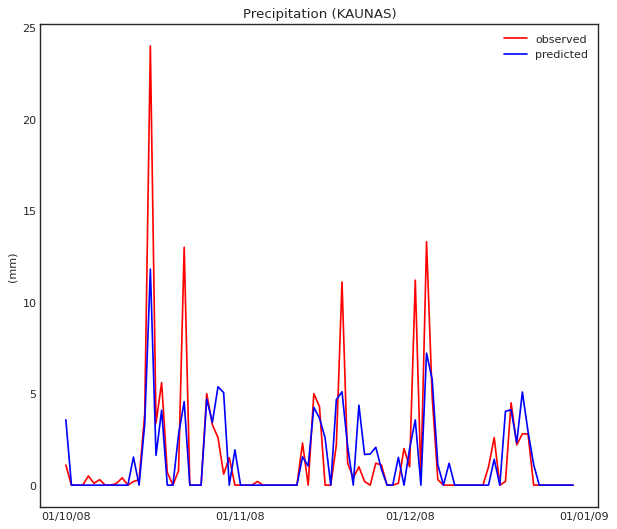

In [13]:
plot_at_station("KAUNAS", stations, pred, precip_obs)

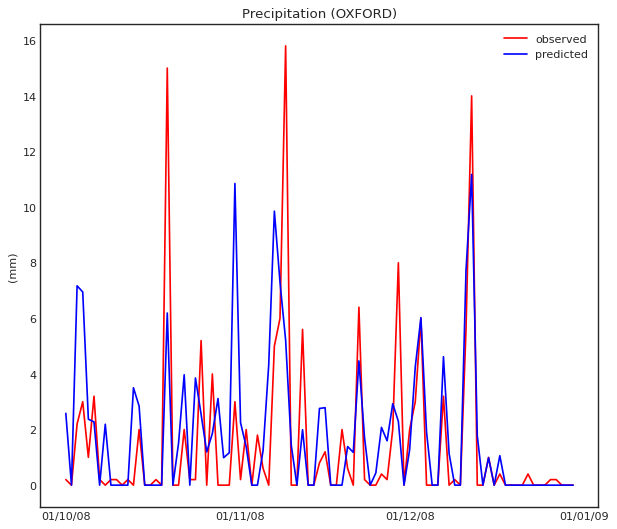

In [14]:
plot_at_station("OXFORD", stations, pred, precip_obs)

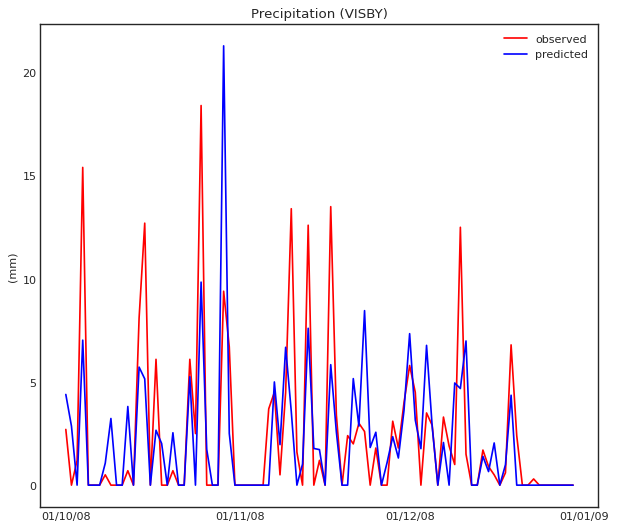

In [15]:
plot_at_station("VISBY", stations, pred, precip_obs)